# Apophis Track Over Earth's Map

Agustín Vallejo

This notebook loads the Ephemeris and Radiotelescope data and plots them into a Basemap plot.


### Documentación

+ Basemap: 
    + https://matplotlib.org/basemap/index.html
    +  https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
+ Animaciones:
    + https://colab.research.google.com/github/phoebe-project/phoebe2-docs/blob/2.1/tutorials/animations.ipynb#scrollTo=lkmX8eKePPA2
    + https://colab.research.google.com/drive/1Ofuol9wHBJKxZlDS4foZ3cm9G8fArOow#scrollTo=rd6h4K9vOtZk

### Librerías

In [1]:
"LIBRERÍAS BÁSICAS"
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
"ASTROPY"
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import astropy.units as u

In [3]:
"MAPITAS"
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     / 133.1 MB 671 kB/s
     |████████████████████████████████| 6.3 MB 5.1 MB/s 
     |████████████████████████████████| 219 kB 52.2 MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759610 sha256=a03b411742f804c4a75c4d857e881848095535931ba0d46f8d35c21e67dfa407
  Stored in directory: /tmp/pip-ephem-wheel-cache-060ybe0g/wheels/98/1a/9d/de6aa4dee52d726996be77bb4a65cf03865288bfc35e5b24d8
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp37-cp37m-linux_x86_64.whl size=3702471 sha256=544a7a04d24c9638dc40a3d231ca985c103d2771412b231ca37c291a31de2b12
  Stored in directory: /root/.cache/pip/wheels/08/60/55/38382877bab48a6abfca7bd66115e287ce5a9530cbce631771
Successfully built pyproj
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.2.1
    Uninstalling pyproj-3.2.1:
      Successfully uninstalled pyproj-3.2.1


In [4]:
"TQDM"
!pip install tqdm
from tqdm import tqdm

## Google Drive

In [5]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [6]:
!ls "/gdrive/MyDrive/Apophis/Data"

'1. Apophis over Earth.png'   observatory_distances.csv
'2. Apophis over USA.png'     observatory_distances_indexes.csv
'3. Apophis over Asia.png'   "Radio coverage Earth's Center.png"
 AllRadiotelescopes.xlsx     'Radio coverage FAST.png'
 ephemeris2.xlsx	     'Radio coverage Goldstone Radio Telescope.png'
 ephemeris3.xlsx	      subradar_points.csv
 ephemeris.xlsx		      utils.ipynb
 fig1:distances.eps	      vectors.xlsx


## Load Data

In [7]:
continents = ['Africa',	'Antarctica','Asia','Australia','Europe','North America','South America',
              'Arctic Ocean','Atlantic Ocean','Indian Ocean','Pacific Ocean']
radio = []

for continent in continents:
  try:
    cont = pd.read_excel("/gdrive/MyDrive/Apophis/Data/AllRadiotelescopes.xlsx",sheet_name=continent,index_col=0)
    radio.append(cont)
  except:
    pass

In [8]:
ephemeris = pd.read_excel("/gdrive/MyDrive/Apophis/Data/ephemeris.xlsx")

## All Radiotelescopes

In [9]:
%cd "/gdrive/MyDrive/Apophis/Data"

/gdrive/MyDrive/Apophis/Data


In [10]:
def get_lon(TIME,RA):
  """
  Saca la Longitud que estará bajo el asteroide en cada momento
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return RA - G.value

maxlons = get_lon(ephemeris['datetime_jd'],ephemeris['RA'])
maxlats = ephemeris['DEC']
deltas = ephemeris['delta (Rt)']

for i in range(len(maxlons)):
  if maxlons[i] < -180: maxlons[i] += 360

for i in range(len(maxlons)-1):
  if maxlons[i+1] > maxlons[i]:
    j = i + 1

def add_nan(array,idx):
    """
    Adds a np.nan in the location idx to split the path into two.
    """
    return list(array[:idx])+[np.nan]+list(array[idx:])

maxlons = add_nan(maxlons,j) #np.insert(maxlons,j,[-180])
maxlats = add_nan(maxlats,j) #np.insert(maxlats,j,[maxlats[j]])
deltas = add_nan(deltas,j) # np.insert(deltas,j,[deltas[j]])


/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "utcut1" yielded 200 of "dubious year (Note 3)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 200 of "dubious year (Note 3)"
  ErfaWarning)


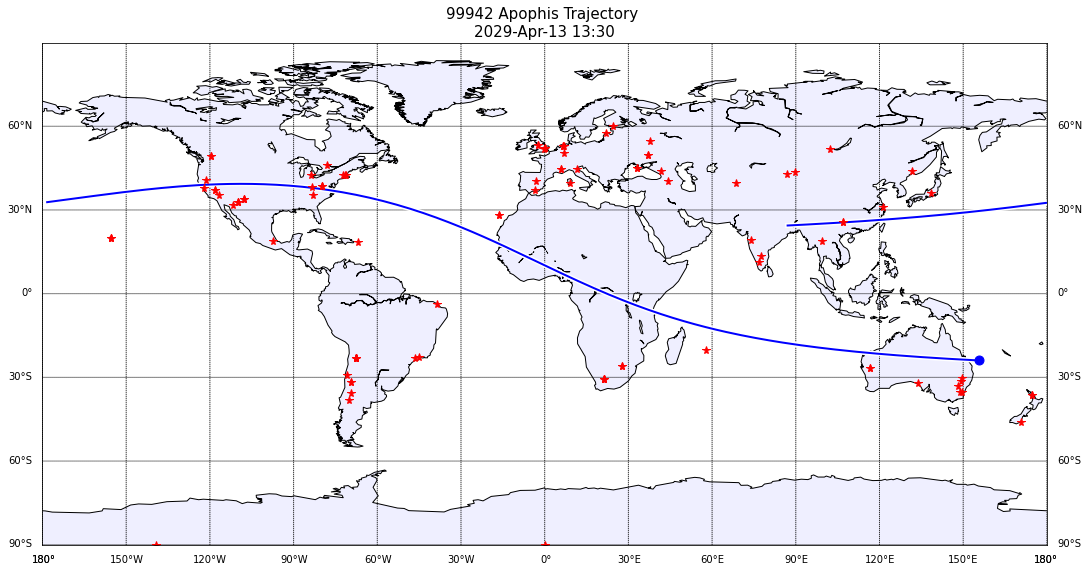

In [11]:
t = 0
fig = plt.figure(figsize=(18,15))
ax = plt.axes()
m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory \n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

for rad in radio:
    for r,row in rad.iterrows():
        plt.plot(row.Longitude,row.Latitude,'r*',ms=8)
        # plt.annotate(str(r),(row.Longitude+5,row.Latitude),size=10)

In [12]:
fig.savefig("1. Apophis over Earth.png")


### USA

Text(-114.89, 35.42666667, 'Goldstone Radio Telescope')

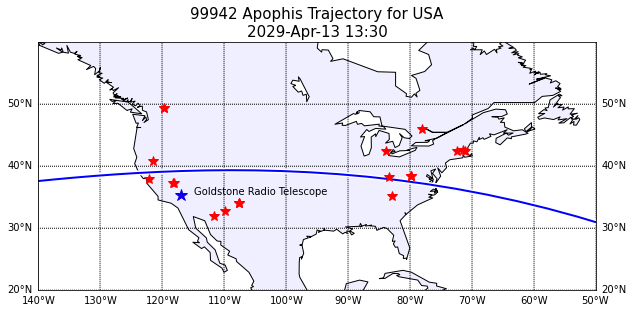

In [13]:
t = 0
fig = plt.figure(figsize=(10,10))
# ax = fig.add_axes(map_ax)
ax = plt.axes()
# ax.clear()
# m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m = Basemap(llcrnrlon=-140,llcrnrlat=20,urcrnrlon=-50,urcrnrlat=60,
            projection='cyl',lon_0=-80,lat_0=40)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(20,60,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-140,-20,10),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory for USA\n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

continent = 5 # America

for r,row in radio[continent].iterrows():
    ax.plot(row.Longitude,row.Latitude,'r*',ms=10)
    # ax.annotate(str(r),(row.Longitude+2,row.Latitude),size=10)

"""
n = 6  # CARMA
n = 10 # Goldstone
n = 11 # Green Bank Interferometer
n = 12 # Green Bank Telescope
n = 12 # Green Bank 140 ft
n = 18 # Leuschner Observatory
n = 20 # Morehead State University 21m
n = 22 # OVRO 40 meter Telescope
n = 28 # VLA
n = 30 # VLBA
n = 31 # PARI
"""


n = 10 # VLBA
single_one = radio[continent].iloc[n]
ax.plot(single_one.Longitude,single_one.Latitude,'b*',ms=12)
ax.annotate(str(single_one.Name),(single_one.Longitude+2,single_one.Latitude),size=10)

In [14]:
fig.savefig("2. Apophis over USA.png")


### FAST

Text(nan, nan, 'Delingha 13.7 m')

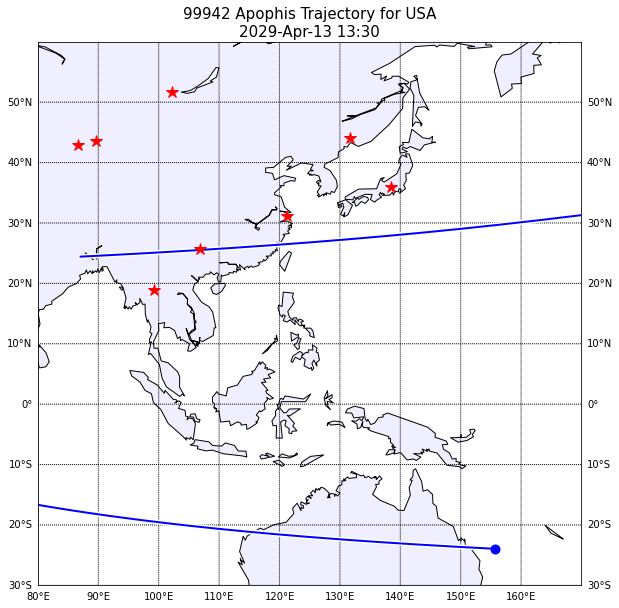

In [15]:
t = 0
fig = plt.figure(figsize=(10,10))
# ax = fig.add_axes(map_ax)
ax = plt.axes()
# ax.clear()
# m = Basemap(ax=ax,projection='cyl', lon_0 = 0, lat_0 = 0)
m = Basemap(llcrnrlon=80,llcrnrlat=-30,urcrnrlon=170,urcrnrlat=60,
            projection='cyl',lon_0=120,lat_0=30)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-30,60,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(80,170,10),labels=[1,1,0,1])
ax.set_title("99942 Apophis Trajectory for USA\n"+str(ephemeris['datetime_str'][t]),size=15)

# Contorno blanco
ax.plot(maxlons,maxlats,'w-',lw=5)
ax.plot(maxlons[t],maxlats[t],'wo',ms=12)

# Relleno azul
ax.plot(maxlons,maxlats,'b-',lw=2)
ax.plot(maxlons[t],maxlats[t],'bo',ms=9)

continent = 2 # Asia

for r,row in radio[continent].iterrows():
    ax.plot(row.Longitude,row.Latitude,'r*',ms=12)
    # ax.annotate(str(r),(row.Longitude+2,row.Latitude),size=10)

n = 0 # FAST
single_one = radio[continent].iloc[n]
ax.plot(single_one.Longitude,single_one.Latitude,'b*',ms=12)
ax.annotate(str(single_one.Name),(single_one.Longitude+2,single_one.Latitude),size=10)

In [16]:
fig.savefig("3. Apophis over Asia.png")


# Refactoring the code

In [17]:
# L = 10
# fig = plt.figure(figsize=(L,L))
# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# ax2 = plt.subplot2grid((2, 2), (1, 0))
# ax3 = plt.subplot2grid((2, 2), (1, 1))

def line_and_radiotelescopes(ax,continent=None):
    # Contorno blanco
    ax.plot(maxlons,maxlats,'w-',lw=5)
    # Relleno azul
    ax.plot(maxlons,maxlats,'b-',lw=2)
    if continent:
        for r,row in radio[continent].iterrows():
            ax.plot(row.Longitude,row.Latitude,'r*',ms=12)
    else:
        for rad in radio:
            for r,row in rad.iterrows():
                plt.plot(row.Longitude,row.Latitude,'r*',ms=8)

Text(0.5, 1.0, '(c)')

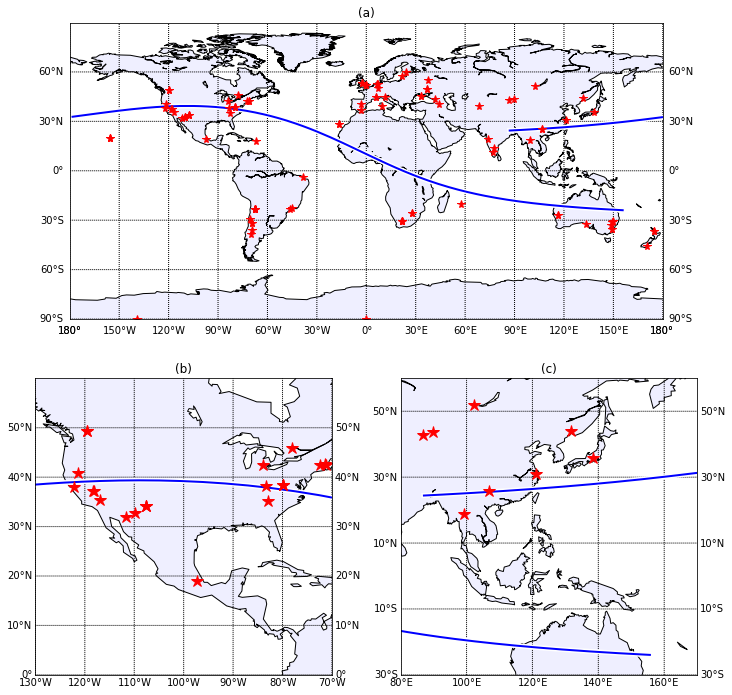

In [18]:
L = 12
fig = plt.figure(figsize=(L,L))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
m = Basemap(ax=ax1,projection='cyl', lon_0 = 0, lat_0 = 0)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
line_and_radiotelescopes(ax1)
ax1.set_title("(a)")

ax2 = plt.subplot2grid((2, 2), (1, 0))
m = Basemap(ax=ax2,llcrnrlon=-130,llcrnrlat=0,urcrnrlon=-70,urcrnrlat=60,
            projection='cyl',lon_0=-80,lat_0=40)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(0,60,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-140,-20,10),labels=[1,1,0,1])
line_and_radiotelescopes(ax2,5)
ax2.set_title("(b)")


ax3 = plt.subplot2grid((2, 2), (1, 1))
m = Basemap(ax=ax3,llcrnrlon=80,llcrnrlat=-30,urcrnrlon=170,urcrnrlat=60,
            projection='cyl',lon_0=120,lat_0=30)
m.fillcontinents(color='#efefff')
m.drawcoastlines()
m.drawparallels(np.arange(-30,60,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(80,170,20),labels=[1,1,0,1])
line_and_radiotelescopes(ax3,2)
ax3.set_title("(c)")


In [20]:
fig.savefig('fig2:maps.eps', format='eps')